# Afriat

In [1]:
import warnings
import os
import sys
import gc

In [2]:
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import tqdm
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
from tardis._utils.warnings import suppress_stdout, ignore_predetermined_warnings
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [4]:
num_ood = 1  # not functioning

In [5]:
def get_availables():
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
    availables = list(df[df>100].index)
    return availables

In [6]:
def get_classification(ood_seed, target_obs):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")
        adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
        adata = ad.read_h5ad(adata_file_path)
        df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
        availables = list(df[df>100].index)
        def adata_ood_creator(adata, seed, size):
            rng = np.random.default_rng(seed=seed)
            # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
            # choices = [availables[i] for i in random_choices]
            choices = [availables[ood_seed]]
            choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
            return adata[~choices_bool, :].copy(), choices_bool, choices[0]
        
        adata, choices_bool, choice = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
    
        dir_path = os.path.join(
            tardis.config.io_directories["models"],
            f"afriat_v2_4_1_ood-seed-{ood_seed}_size-{num_ood}"
        )
        vae = tardis.MyModel.load(dir_path, adata=adata)
        from tardis._disentanglementmanager import DisentanglementManager as DM
    
        adata_main = ad.read_h5ad(adata_file_path)
        adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
        adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")
        adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()
    
        k = target_obs
        
        latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
        sc.pp.neighbors(latent, n_neighbors=90)
        
        latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
        sc.pp.neighbors(latent_ood, n_neighbors=90)
        
        label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=90)
        predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
        true = latent_ood.obs[k].astype(str).values

        t = latent.obs[k].astype(str).to_numpy().copy()
        dummy_clf = DummyClassifier(strategy="stratified")
        dummy_clf.fit(t.reshape(-1, 1), t)
        dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
        
        result = {
            "accuracy": sklearn.metrics.accuracy_score(true, predicted), 
            "baseline": sklearn.metrics.accuracy_score(t, dummy_predictions)
        }
        result.update({f"OOD_{i}": choice[ind] for ind, i in enumerate(['time_cat', 'zone', 'status_control'])})
        return result
        

In [7]:
result = []
for z in ['time_cat', 'zone', 'status_control']:
    for i in tqdm.tqdm(range(len(get_availables())), desc=z):
        d = get_classification(i, z)
        d.update({"target_covariate": z})
        result.append(d)

status_control: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:29<00:00, 24.25s/it]


In [8]:
df = pd.DataFrame(result)
df

,accuracy,baseline,OOD_time_cat,OOD_zone,OOD_status_control,target_covariate
0,0.983516,0.179175,0.0,Pericentral,Control,time_cat
1,0.831892,0.203550,0.0,Periportal,Control,time_cat
2,0.972067,0.177758,12.0,Pericentral,Infected,time_cat
3,0.987745,0.179726,12.0,Pericentral,Uninfected,time_cat
4,0.995804,0.182899,12.0,Periportal,Infected,time_cat
...,...,...,...,...,...,...
58,0.824507,0.438695,30.0,Periportal,Uninfected,status_control
59,0.629121,0.466317,36.0,Pericentral,Infected,status_control
60,0.938065,0.440858,36.0,Pericentral,Uninfected,status_control
61,0.504868,0.473383,36.0,Periportal,Infected,status_control


<Axes: xlabel='OOD_time_cat', ylabel='accuracy'>

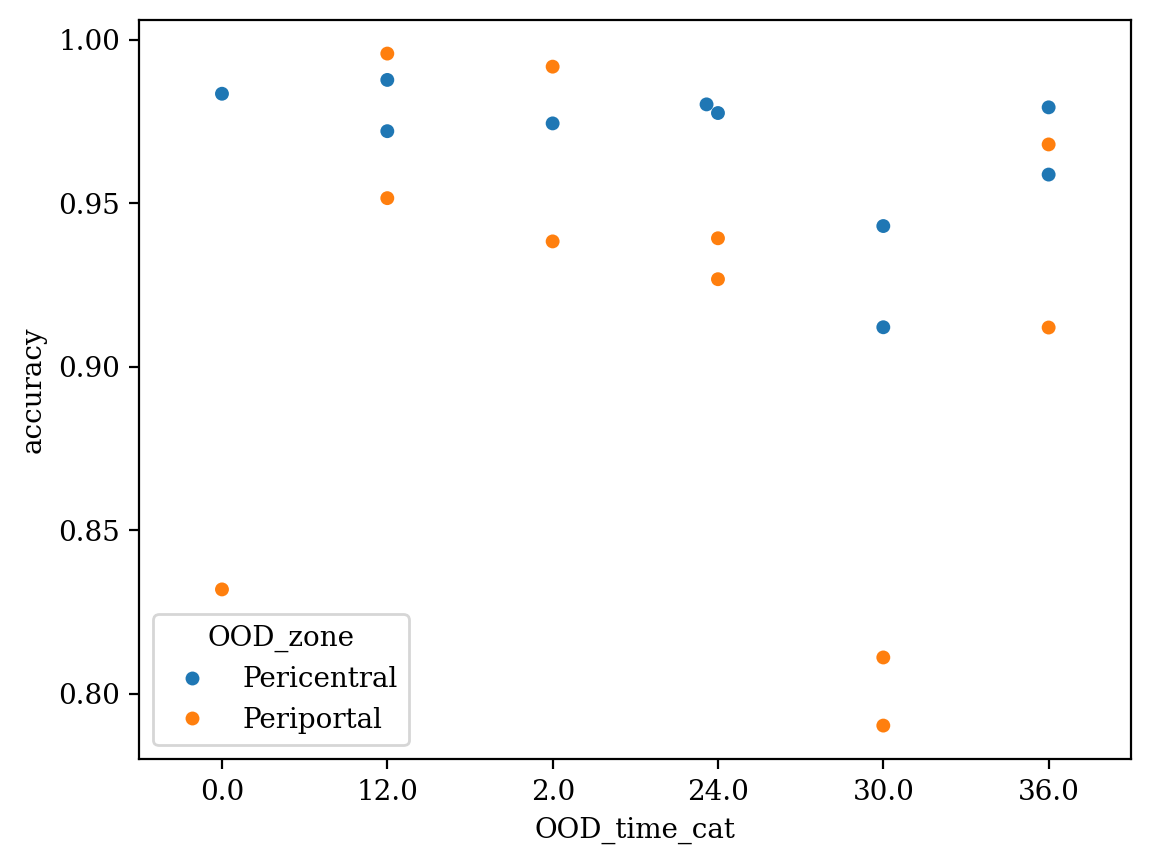

In [9]:
sns.swarmplot(data=df[df["target_covariate"] == "time_cat"], x="OOD_time_cat", y="accuracy", hue="OOD_zone")

<Axes: xlabel='OOD_status_control', ylabel='accuracy'>

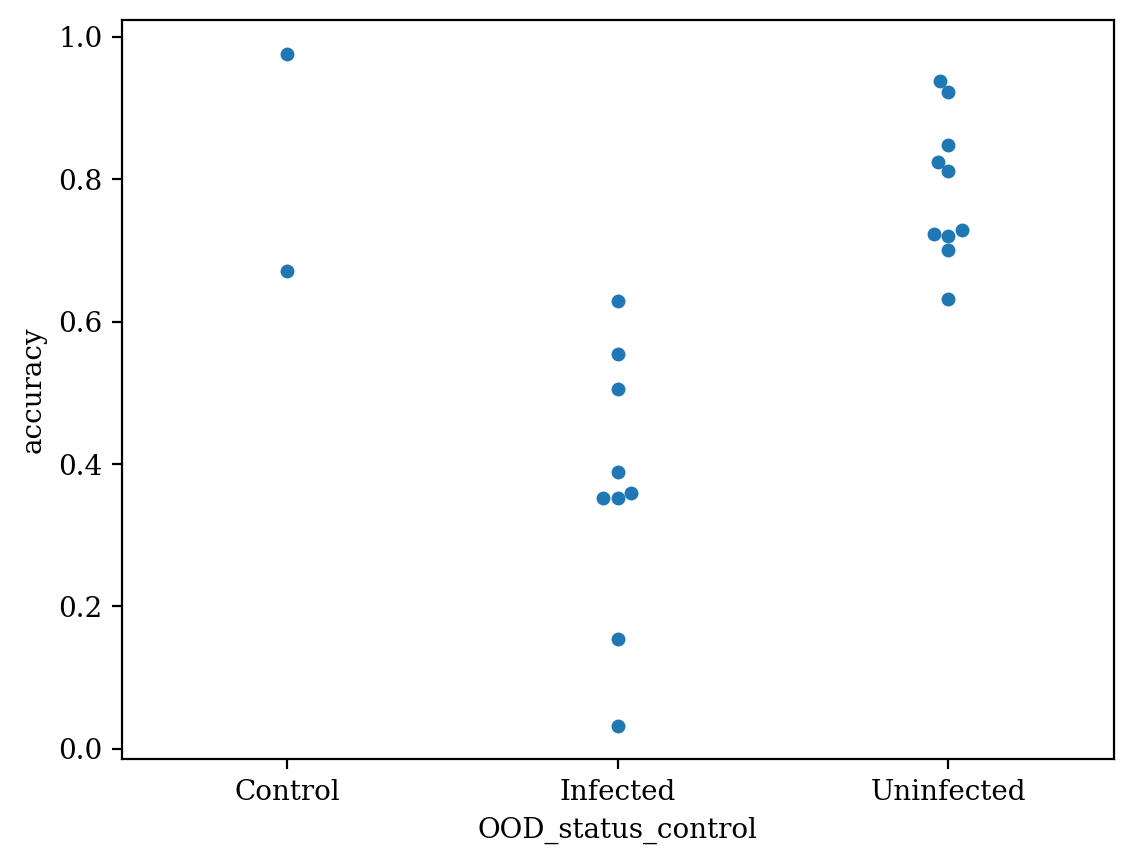

In [10]:
sns.swarmplot(data=df[df["target_covariate"] == "status_control"], x="OOD_status_control", y="accuracy")

<Axes: xlabel='target_covariate', ylabel='accuracy'>

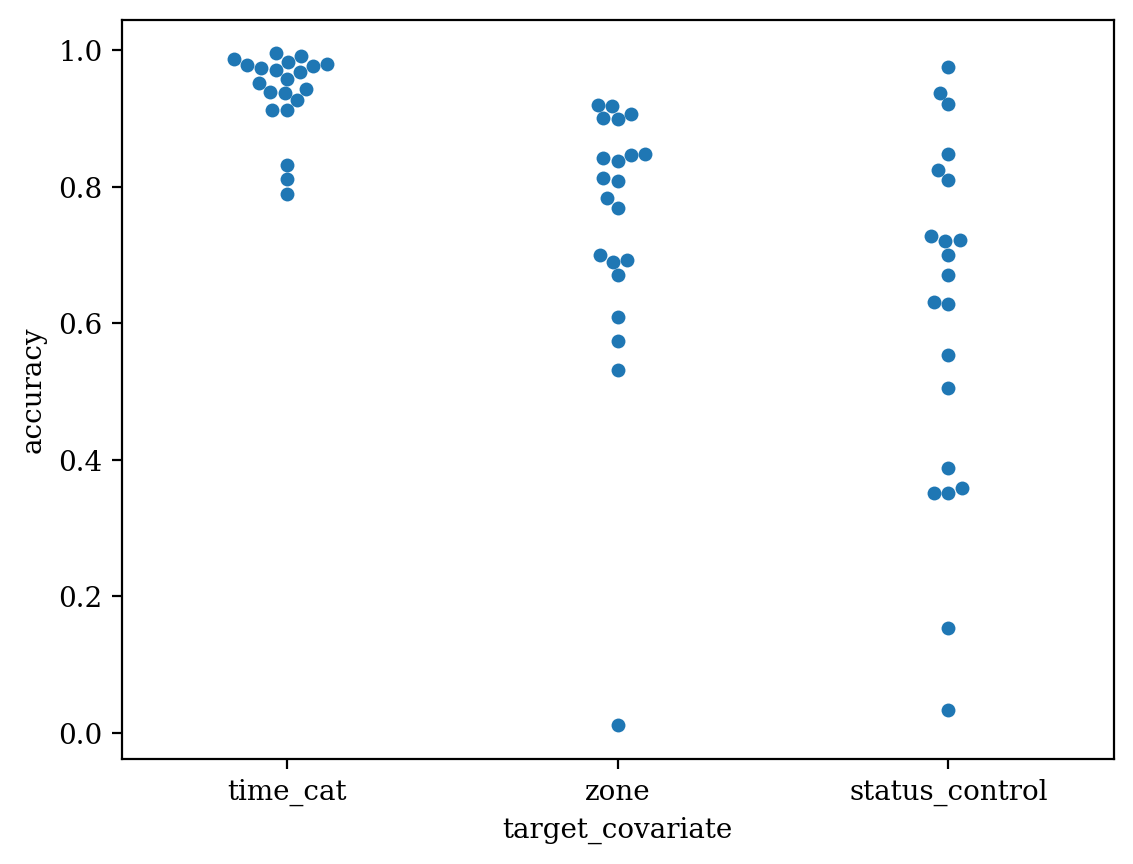

In [14]:
sns.swarmplot(data=df, x="target_covariate", y="accuracy")

In [13]:
df.to_pickle(
    os.path.join(tardis.config.io_directories["processed"], "figures", "figure4_afriat.pickle")
)